Importing Necessary Packages

In [2]:
import pandas as pd
import yfinance as yf
import numpy as np
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Input, Activation,concatenate, Attention, Bidirectional,GlobalAveragePooling1D
from keras import optimizers
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import LeakyReLU
import matplotlib.pyplot as plt
import keras_tuner as kt
import math
from datetime import datetime, timedelta
from scipy.stats import norm

Data Pull and Plot

In [3]:
start_date = '2016-01-01'
today = datetime.now()
end_date = datetime.strftime(today, '%Y-%m-%d')
#end_date = '2024-01-08'
display(end_date)
data = yf.download("ETH-USD", start=start_date, end=end_date) #Displays till yesterday as today is not complete
data = data.reset_index()
dates = data['Date']

'2024-01-11'

KeyboardInterrupt: 

In [ ]:
dataclose = data.reset_index()['Close']
plt.plot(dataclose)

In [ ]:
scaler = MinMaxScaler()
dataclose = scaler.fit_transform(np.array(dataclose).reshape(-1,1))
dataclose.shape

In [ ]:
train_size = int(len(dataclose)*0.6)
test_size = len(dataclose) - train_size
train_data,test_data = dataclose[0:train_size,:],dataclose[train_size:len(dataclose),:1]

In [ ]:
def create_dataset(dataset, time_step = 1):
    dataX,dataY = [],[]
    for i in range(len(dataset)-time_step-1):
                   a = dataset[i:(i+time_step),0]
                   dataX.append(a)
                   dataY.append(dataset[i + time_step,0])
    return np.array(dataX),np.array(dataY)

In [ ]:
# calling the create dataset function to split the data into 
# input output datasets with time step 100
time_step = 100
X_train,Y_train =  create_dataset(train_data,time_step)
X_test,Y_test =  create_dataset(test_data,time_step)

In [ ]:
model = Sequential()
model.add(LSTM(50,return_sequences = True,input_shape = (X_train.shape[1],1)))
model.add(LSTM(50,return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error',optimizer = 'adam')

In [ ]:
model.fit(X_train,Y_train,validation_data = (X_test,Y_test),epochs = 50,batch_size = 64,verbose = 1)

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [ ]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [ ]:
print(math.sqrt(mean_squared_error(Y_train,train_predict)) / Y_train.shape[0])
print(math.sqrt(mean_squared_error(Y_test,test_predict)) / Y_test.shape[0])

In [ ]:
look_back = 100

In [ ]:
trainPredictPlot = np.empty_like(dataclose)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back : len(train_predict)+look_back,:] = train_predict

In [ ]:
testPredictPlot = np.empty_like(dataclose)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back)*2 + 1 : len(dataclose) - 1,:] = test_predict

In [ ]:
plt.plot(scaler.inverse_transform(dataclose))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
prediction_data = np.array(dataclose[-100:]).transpose()
prediction = scaler.inverse_transform(model.predict(prediction_data))[0][0]
print("Prediction for: ", end_date, "        CLOSE: ", prediction)

In [ ]:
results = []
runs = 100
for i in range(runs):
    print("RUN: ", i+1)
    model = Sequential()
    model.add(LSTM(50,return_sequences = True,input_shape = (X_train.shape[1],1)))
    model.add(LSTM(50,return_sequences = True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss = 'mean_squared_error',optimizer = 'adam')
    model.fit(X_train,Y_train,validation_data = (X_test,Y_test),epochs = 10,batch_size = 64,verbose = 1)
    prediction = scaler.inverse_transform(model.predict(prediction_data))[0][0]
    print("Prediction for: ", end_date, "        CLOSE: ", prediction)
    results.append(prediction)

plt.hist(results)
mu, std = norm.fit(data)
xmin, xmax = plt.xlim() 
x = np.linspace(xmin, xmax, 100) 
p = norm.pdf(x, mu, std) 
  
plt.plot(x, p, 'k', linewidth=2) 
title = "Fit Values: {:.2f} and {:.2f}".format(mu, std) 
plt.title(title)
plt.show()   

In [ ]:
print(results)

In [4]:
def LSTMPrediction(datafile = 'lstm_data.csv', time_step = 10, runs = 30):

    datadf = pd.read_csv(datafile)[-700:]
    yest = (np.array(datadf['Date'])[-1])
    yest=datetime.strptime(yest,'%Y-%m-%d')
    end_date=yest+timedelta(1)
    end_date = datetime.strftime(end_date, '%Y-%m-%d')
    training_df = datadf[['Close', 'Open', 'High', 'Low', 'Volume', 'Sentiment']]

    #Data Scaling
    Xscaler = MinMaxScaler()
    Xdata = Xscaler.fit_transform(np.array(training_df))
    Xdata.shape
    Yscaler = MinMaxScaler()
    Ydata = Yscaler.fit_transform(np.array([training_df['Close']]).transpose())

    Xtrain_data, Xtest_data = train_test_split(Xdata, test_size=0.3, shuffle=False)
    Ytrain_data, Ytest_data = train_test_split(Ydata, test_size=0.3, shuffle=False)
    
    def build_timeseries(Xdata, Ydata, time_step):
        dim_0 = Xdata.shape[0] - time_step
        dim_1 = Xdata.shape[1]

        x = np.zeros((dim_0, time_step, dim_1))
        y = np.zeros((Ydata.shape[0] - time_step,))

        for i in range(dim_0):
            x[i] = Xdata[i:time_step+i]
            y[i] = Ydata[time_step+i]
        return x, y

    
    X_train, Y_train = build_timeseries(Xtrain_data, Ytrain_data.transpose()[0], time_step)
    X_test, Y_test = build_timeseries(Xtest_data, Ytest_data.transpose()[0], time_step)

    X_train = X_train.reshape((X_train.shape[0], time_step, X_train.shape[2]))
    X_test = X_test.reshape((X_test.shape[0], time_step, X_test.shape[2]))

    results = []
    prediction_data = np.array([X_test[-1]])
    for i in range(runs):
        print("RUN: ", i+1)
        model = Sequential()
        model.add(LSTM(50,return_sequences = True,input_shape = (X_train.shape[1],X_train.shape[2])))
        model.add(LSTM(50,return_sequences = True))
        model.add(LSTM(50,return_sequences = True))
        model.add(GlobalAveragePooling1D())
        model.add(Dense(25,activation='relu'))
        model.add(Dense(25))
        model.compile(loss = 'mean_squared_error',optimizer = 'adam')
        lstm_model = model.fit(X_train,Y_train,validation_data = (X_test,Y_test),epochs = 25,batch_size = 64, verbose = 1)
        prediction = model.predict(prediction_data)
        prediction = Yscaler.inverse_transform(prediction)[0][0]
        print("Prediction for: ", end_date, "        CLOSE: ", prediction)
        results.append(prediction)

    lastclose = Yscaler.inverse_transform([Ydata[-1]])[0][0]
    adjresults = np.array([x - lastclose for x in results])
    mu = adjresults.mean()
    std = adjresults.std()

    fig, ax = plt.subplots()
    xmin, xmax = plt.xlim()
    diff = pd.DataFrame(adjresults) 
    kde = diff.plot.kde(ax=ax, legend = False)
    diff.plot.hist(density=True, ax=ax, bins=20)
    title = "Fit Values: {:.2f} and {:.2f}".format(mu, std) 
    plt.title(title)
    plt.show()
    
    #Returns average change in price
    return mu, std

RUN:  1


Epoch 1/25

8/8 [==============================] - 6s 147ms/step - loss: 0.1423 - val_loss: 0.1146
Epoch 2/25
8/8 [==============================] - 0s 18ms/step - loss: 0.1211 - val_loss: 0.0844
Epoch 3/25
8/8 [==============================] - 0s 18ms/step - loss: 0.0960 - val_loss: 0.0624
Epoch 4/25
8/8 [==============================] - 0s 19ms/step - loss: 0.0741 - val_loss: 0.0460
Epoch 5/25
8/8 [==============================] - 0s 21ms/step - loss: 0.0538 - val_loss: 0.0305
Epoch 6/25
8/8 [==============================] - 0s 24ms/step - loss: 0.0349 - val_loss: 0.0199
Epoch 7/25
8/8 [==============================] - 0s 20ms/step - loss: 0.0245 - val_loss: 0.0132
Epoch 8/25
8/8 [==============================] - 0s 20ms/step - loss: 0.0152 - val_loss: 0.0064
Epoch 9/25
8/8 [==============================] - 0s 20ms/step - loss: 0.0104 - val_loss: 0.0041
Epoch 10/25
8/8 [==============================] - 0s 21ms/step - loss: 0.0081 - val_loss: 0.0032
Epoch 11/25
8/8 [

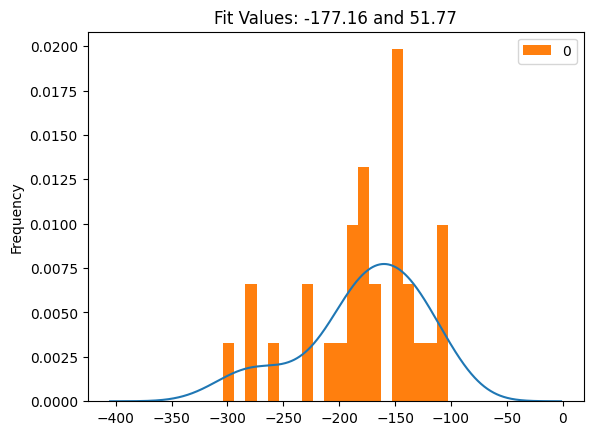

(-177.16271972656213, 51.77315521384896)

In [5]:
LSTMPrediction()